In [1]:
import selfies as sf
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import torch
import torch.nn as nn
import random, glob, os
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit import Chem
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../smiles_selfies_full.csv')

### Tokenization

In [3]:
df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [PAD, SOS, EOS] + vocab

tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

def tokens_to_ids(tokens, tok2id):
    return np.array([tok2id[t] for t in tokens])

df['token_ids'] = df['tokens'].apply(lambda toks: tokens_to_ids(toks, tok2id))

### Data prep

In [4]:
sequences = df['token_ids'].tolist()
max_len = max(len(seq) for seq in sequences)
padded_data = np.zeros((len(sequences), max_len), dtype=sequences[0].dtype)

for i, seq in enumerate(sequences):
    padded_data[i, :len(seq)] = seq

data = padded_data
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
val_data, test_data = train_test_split(data, test_size=0.5, random_state=42, shuffle=True)
print(max_len)

75


### Model

In [7]:
class BaselineVAE(nn.Module):
    def __init__(self, vocab_size, max_len, embed_size=64, hidden_size=128, latent_size=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.start_T = 5
        self.max_len = max_len

        self.encoder = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=5, padding=2, dilation=1),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=4, dilation=2),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=8, dilation=4),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=16, dilation=8),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=32, dilation=16),
            nn.ReLU(),
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        self.fc_z = nn.Linear(latent_size, hidden_size * self.start_T)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 7, stride=1, padding=6)
        )        
        self.output_fc = nn.Linear(hidden_size, vocab_size)

    def encode(self, x):
        h = self.embed(x).transpose(1,2)
        h = self.encoder(h)
        h = self.pool(h).squeeze(-1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        # mu = h[:, :self.latent_size]
        # logvar = h[:, self.latent_size:]
        return mu, logvar
    
    def decode(self, z):
        B = z.size(0)
        h = self.fc_z(z)
        h = h.view(B, self.hidden_size, self.start_T)
        h = self.decoder(h)            # [B, H, T]
        #h = h[:, :, :self.max_len]     # ensure exact T
        #logits = h.transpose(1,2)      # [B, T, vocab_size]   
        logits = self.output_fc(h.transpose(1, 2))  # [B, T, vocab]
        return logits
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        logits = self.decode(z)
        return logits, mu, logvar
    
    def encode_sequence(self, x, batch_size=256):
        self.eval()
        device = next(self.parameters()).device
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.long)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        loader = DataLoader(TensorDataset(x), batch_size=batch_size)
        logits_list, mu_list, logvar_list = [], [], []
        with torch.no_grad():
            for (bx,) in loader:
                bx = bx.to(device)
                logits, mu, logvar = self(bx)
                #logits_list.append(logits.cpu())
                mu_list.append(mu.cpu())
                logvar_list.append(logvar.cpu())
        #logits = torch.cat(logits_list, dim=0)
        mu = torch.cat(mu_list, dim=0)
        logvar = torch.cat(logvar_list, dim=0)
        return logits, mu, logvar
    
def vae_loss(logits, x, mu, logvar, beta=0.1, pad_id=0):
    B, T, V = logits.shape
    logits_flat = logits.reshape((B*T, V))
    targets_flat = x[:, :T].reshape(B*T)

    mask = (targets_flat != pad_id)
    valid_logits = logits_flat[mask]
    valid_targets = targets_flat[mask]
    
    rec_loss = F.cross_entropy(valid_logits, valid_targets)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = rec_loss + beta * kl_loss
    return loss, rec_loss, kl_loss

### Training

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = BaselineVAE(vocab_size=len(vocab), max_len=train_data.shape[-1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 10
beta = 0.01
batch_size = 512

train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=True)
history = []

for epoch in range(1, epochs + 1):
    model.train()
    total_recon = 0
    total_kl = 0
    val_recon = 0
    val_kl = 0

    for x in train_loader:
        x = x.to(device)

        logits, mu, logvar = model(x)        
        loss, rec, kl = vae_loss(logits, x, mu, logvar, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_recon += rec.item()
        total_kl += kl.item()

    with torch.no_grad():
        for x in val_loader:
            x = x.to(device)
            logits, mu, logvar = model(x)
            loss, rec, kl = vae_loss(logits, x, mu, logvar, beta)
            val_recon += rec.item()
            val_kl += kl.item()

    val_loss = val_recon + val_kl
    history.append((total_recon / len(train_loader), total_kl / len(train_loader), val_loss/len(val_loader)))
    print(f"Epoch {epoch:03d} | recon={total_recon/len(train_loader):.4f} | KL={total_kl/len(train_loader):.4f} | val={val_loss/len(val_loader)}")


Epoch 001 | recon=2.0027 | KL=0.7283 | val=3.062180059933171
Epoch 002 | recon=1.3900 | KL=1.6882 | val=3.042894803218006
Epoch 003 | recon=1.0986 | KL=1.8590 | val=2.8680274806839905
Epoch 004 | recon=0.9417 | KL=1.9001 | val=2.7854761129494796
Epoch 005 | recon=0.8688 | KL=1.9368 | val=2.9854216174673787
Epoch 006 | recon=0.8120 | KL=1.9067 | val=2.6700505447602763
Epoch 007 | recon=0.6840 | KL=1.9396 | val=2.58426684095073
Epoch 008 | recon=0.6039 | KL=1.9625 | val=2.5428387578000726
Epoch 009 | recon=0.5693 | KL=1.9719 | val=2.4934356231050394
Epoch 010 | recon=0.4897 | KL=1.9623 | val=2.4509961009793675


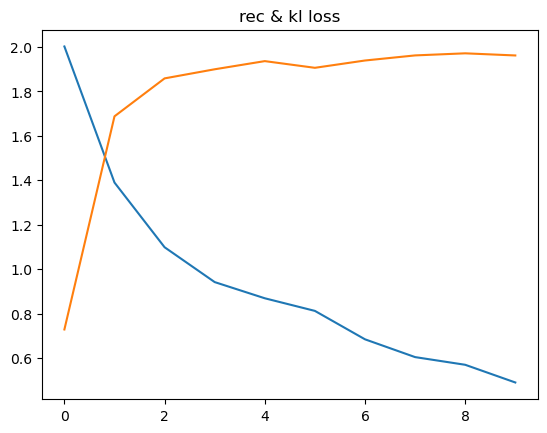

In [10]:
plt.plot(np.array(history)[:, 0])
plt.title('rec & kl loss')
plt.plot(np.array(history)[:, 1])
plt.show()

In [11]:
logits, mu, logvar = model.encode_sequence(val_data)
z = mu
z = z.cpu().numpy()

### Visualization 

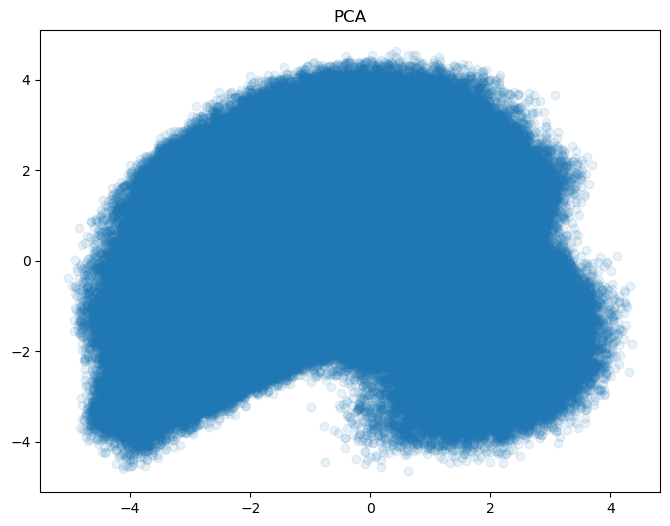

In [12]:
pca_z = PCA(n_components=2).fit_transform(z)
plt.figure(figsize=(8,6))
plt.scatter(pca_z[:, 0], pca_z[:, 1], alpha=0.1)
plt.title('PCA')
plt.show()

### Testing latent

In [13]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(id)] for id in tokens]
    return str(selfie_tokens)

In [20]:
x = val_data[0:1]
print(x.shape)
logits, mu, logvar = model.encode_sequence(x)
print(logits.shape)
tokens = torch.argmax(logits, dim=-1)
print(tokens_to_selfie(x[0]))
print(tokens_to_selfie(tokens[0]))

(1, 75)
torch.Size([1, 74, 110])
['[C]', '[C]', '[=C]', '[Branch1]', '[C]', '[F]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[#Branch1]', '[C@@]', '[C]', '[C]', '[C@@H1]', '[Branch1]', '[Ring2]', '[C]', '[Ring1]', '[Branch1]', '[O]', '[C]', '[Ring1]', '[#Branch1]', '[=O]', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['[C]', '[C]', '[=C]', '[Branch1]', '[C]', '[Cl]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[#Branch1]', '[C]', '[Branch1]', '[C]', '[C]', '[Branch1]', '[Ring2]', '[C]', '[Ring1]', '[Ring1]', '[C]', '[Ring1]', '[Ring1]', '[#Branch1]', '[=O]', '[=O]', '[=O]', '[#N]', '[#N]', '[=N+1]',

In [39]:
def get_accuracy(model, pad_id, data, num_samples=5):
    model.eval()    
    accs = []

    for _ in range(num_samples):
        i = np.random.randint(0, len(data))
        x = data[i]
        x = x[np.newaxis, :]
        logits, mu, logvar = model.encode_sequence(x)
        x_rec = torch.argmax(logits, dim=-1)
        acc, pad = 0, 0
        j = 0
        x = x.squeeze(0)
        x_rec = x_rec.squeeze(0)
        while x[j] != pad_id:
            pad += 1
            if x[j] == x_rec[j]:
                acc += 1
            j+=1
        acc = acc / pad
        print(f"real: {tokens_to_selfie(x)}")
        print(f"rec: {tokens_to_selfie(x_rec)}")
        print(f"accuracy: {acc}")
        print('------------------------------')

In [46]:
get_accuracy(model, 0, val_data, num_samples=5)

real: ['[O]', '[C]', '[Branch2]', '[Ring2]', '[Branch2]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[C]', '[F]', '[C]', '[Branch2]', '[Ring1]', '[=Branch2]', '[C]', '[=N]', '[C]', '[=N]', '[C]', '[=C]', '[C]', '[Branch1]', '[=Branch2]', '[N]', '[C]', '[C]', '[O]', '[C]', '[C]', '[Ring1]', '[=Branch1]', '[=C]', '[C]', '[=C]', '[Ring1]', '[S]', '[Ring1]', '[N]', '[=C]', '[Ring2]', '[Ring1]', '[#Branch1]', '[C]', '[=C]', '[N]', '[=C]', '[C]', '[Branch1]', '[C]', '[F]', '[=C]', '[Ring1]', '[#Branch1]', '[Cl]', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
rec: ['[O]', '[C]', '[Branch2]', '[Ring2]', '[Branch2]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[C]', '[F]', '[C]', '[Branch2]', '[Ring1]', '[#Branch1]', '[C]', '[C]', '[=C]', '[=C]', '[C]', '[=C]', '[C]', '[Branch1]', '[=Branch2]', '[N]', '[C]', '[C]', '[O]', '[C]', '[C]', '[Ring1]', '[=Branch1]', '[=C]', '[